# The goal of this notebook is to model monthly aggregated ratings with a DFM

## Read in data, format into monthly aggregates

In [1]:
import pandas as pd, numpy as np, os
% matplotlib inline
from matplotlib import pyplot as plt

In [2]:
os.listdir('/mnt/data/datasets/yougov/data/')

['hotel_vinfo.txt',
 'gd_brand_url.txt',
 'hotel_brand_data.txt',
 'hbrands.txt',
 'hotelvenues.txt',
 'Hotel_Websites_PreMatched',
 'branded_ta_reviews_052817.txt',
 'brands_hotels_panel.txt',
 'mthly_brand_10_22_17.txt',
 'hotelvenues2.txt']

In [3]:
df = pd.read_csv('/mnt/data/datasets/yougov/data/hotel_brand_data.txt', sep = '|', encoding='utf-8', index_col = 0)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (25,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df.review_date = pd.to_datetime(df.review_date)

In [5]:
import datetime
df['ym'] = df.review_date.apply(lambda x:datetime.date(x.year, x.month, 1))

In [6]:
sorted(df.ym.unique())

[datetime.date(2001, 8, 1),
 datetime.date(2001, 10, 1),
 datetime.date(2001, 11, 1),
 datetime.date(2001, 12, 1),
 datetime.date(2002, 1, 1),
 datetime.date(2002, 2, 1),
 datetime.date(2002, 3, 1),
 datetime.date(2002, 4, 1),
 datetime.date(2002, 5, 1),
 datetime.date(2002, 6, 1),
 datetime.date(2002, 7, 1),
 datetime.date(2002, 8, 1),
 datetime.date(2002, 9, 1),
 datetime.date(2002, 10, 1),
 datetime.date(2002, 11, 1),
 datetime.date(2002, 12, 1),
 datetime.date(2003, 1, 1),
 datetime.date(2003, 2, 1),
 datetime.date(2003, 3, 1),
 datetime.date(2003, 4, 1),
 datetime.date(2003, 5, 1),
 datetime.date(2003, 6, 1),
 datetime.date(2003, 7, 1),
 datetime.date(2003, 8, 1),
 datetime.date(2003, 9, 1),
 datetime.date(2003, 10, 1),
 datetime.date(2003, 11, 1),
 datetime.date(2003, 12, 1),
 datetime.date(2004, 1, 1),
 datetime.date(2004, 2, 1),
 datetime.date(2004, 3, 1),
 datetime.date(2004, 4, 1),
 datetime.date(2004, 5, 1),
 datetime.date(2004, 6, 1),
 datetime.date(2004, 7, 1),
 datetime.d

In [7]:
numcols = df.describe().columns.values

In [8]:
cols = [c for c in numcols if ('rating' in c)|('sub' in c)][:-1]

In [9]:
temp = df.groupby(['gd', 'ym'])[cols].mean().reset_index()

In [10]:
temp.columns.values

array(['gd', 'ym', u'review_rating', u'review_sub_Service',
       u'review_sub_Cleanliness',
       u'review_sub_Business service (e.g., internet access)',
       u'review_sub_Check in / front desk', u'review_sub_Value',
       u'review_sub_Sleep Quality', u'review_sub_Rooms',
       u'review_sub_Location', u'rating_vol'], dtype=object)

In [11]:
brand = df[['gd', 'brand_filtered2']].groupby('gd')['brand_filtered2'].first().reset_index()

In [12]:
temp = temp.merge(brand, how = 'left', on = 'gd')

In [13]:
# temp.to_csv('/mnt/data/datasets/yougov/data/mthly_brand_10_22_17.txt', sep = '|' ,encoding = 'utf-8')

In [14]:
temp.rename(columns = {'brand_filtered2':'brand'}, inplace = True)

In [15]:
temp.brand.unique()

array([u'holiday_inn', u'hilton', nan, u'towneplace_suites', u'days_inn',
       u'doubletree', u'best_western', u'marriott', u'crowne_plaza',
       u'sheraton', u'ramada', u'westin', u'holiday_inn_express',
       u'comfort_inn', u'wyndham', u'intercontinental', u'four_seasons',
       u'the_peninsula', u'grand_hyatt', u'hyatt_regency', u'park_hyatt',
       u'jw_marriott', u'motel_6', u'carlton', u'radisson',
       u'hilton_garden_inn', u'super_8', u'w', u'hampton_inn',
       u'springhill_suites', u'hyatt_house', u'hyatt', u'hyatt_place',
       u'ritz', u'omni', u'hotel_indigo', u'econo_lodge', u'residence_inn',
       u'courtyard_by_marriott', u'homewood_suites', u'la_quinta_inn',
       u'red_roof_inn', u'mandarin_oriental', u'andaz', u'waldorf_astoria',
       u'kimpton', u'embassy_suites', u'shangri_la', u'hyatt_centric'], dtype=object)

# Factor Model Code

In [1]:
from scipy.linalg import block_diag
from scipy.stats import zscore
from __future__ import division
# seasonal component:
import numpy as np, pandas as pd
from scipy import eye, asarray, dot
from scipy.linalg import svd
from numpy import diag
def local_trend_component(p):
    return np.kron(np.triu(np.ones([2,2])), np.eye(p))
def seasonal_component(seasons, p):
    Ip = np.eye(p)
    x = np.kron(np.diag(np.ones(seasons-2), k = -1), Ip)
    y = np.kron(np.ones([1, seasons-1]), -Ip)
    x[:p, :] = y
    return x
def combine_components(listofcomponents):
    return block_diag(*listofcomponents)
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    from scipy import sum
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in xrange(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)

In [2]:
from numpy import dot
from numpy.linalg import pinv, norm,inv
class KF_DFM(object):
    def __init__(self,y,x,W,Sigma_u,Sigma_v,A,B,C,D, p=2, n = 'default',sig0=5):
        self.p = p
        if n == 'default':
            self.n = y.shape[1]
        else:
            self.n = n
        self.mu_0 = np.zeros([C.shape[0], 1])
        self.Sigma_0 = np.eye(C.shape[0])*sig0
        self.Sigma_u = Sigma_u
        self.Sigma_v = Sigma_v
        self.ll = None
        if len(y.shape)!=3:
            self.y = y.reshape([y.shape[0], y.shape[1], 1])
        else:
            self.y = y
        try:
            if len(x.shape)!=3:
                self.x = x.reshape([x.shape[0], x.shape[1], 1])
            else:
                self.x = x
        except:
            self.x = None
        
        self.A = A
        self.B = B
        self.C = C
        self.D = D
    
    def kfilter(self, returns = False):        
        Hs=list()
        Ls=list()
        zs=list()
        Qs=list()
        if (self.D == None) | (np.count_nonzero(self.D)==0):
            z=dot(self.C,self.mu_0)
        else:
            z=dot(self.C,self.mu_0)+dot(self.D, self.W[0])
        Q=dot(self.C,dot(self.Sigma_0,self.C.T))+self.Sigma_v
        zs.append(z)
        Qs.append(Q)
        for t in range(len(self.y)):
            H_t_dot = dot(self.A.T, inv(dot(dot(self.A,Q), self.A.T)+self.Sigma_u))
            K_t_dot=dot(dot(self.C,Q),H_t_dot)
            L_t = self.C-dot(K_t_dot,self.A)
            if ((self.D == None) | (np.count_nonzero(self.D)==0))&((self.B == None) | (np.count_nonzero(self.B)==0)):
                z = dot(L_t,z)+dot(K_t_dot,self.y[t])
            elif (self.D == None) | (np.count_nonzero(self.D)==0):
                z = dot(L_t,z)+dot(K_t_dot,(self.y[t]-dot(self.B,self.x[t])))
            elif (self.B == None) | (np.count_nonzero(self.B)==0):
                z = dot(L_t,z)+dot(K_t_dot,self.y[t])+dot(self.D,self.w[t])
            else:
                z = dot(L_t,z)+dot(K_t_dot,(self.y[t]-dot(self.B,self.x[t])))+dot(self.D,self.w[t])
            Q=dot(dot(L_t,Q),self.C.T)+self.Sigma_v
            Hs.append(H_t_dot)
            Ls.append(L_t)
            zs.append(z)
            Qs.append(Q)
            
        self.Hs = Hs
        self.Ls = Ls
        self.zs = zs
        self.Qs = Qs
        if returns == True:
            return self.zs, self.Qs
    def ksmoother(self, returns = False):
        zsmooth = list()
        zvarsmooth = list()
        zcovarsmooth = list()
        rs = list()
        r = np.zeros(self.zs[0].shape)
        R = np.zeros(self.Qs[0].shape)
        I = np.eye(self.zs[-1].shape[0])
        for t in range(len(self.y))[::-1]:
            H_t_dot = self.Hs[t]
            y_t = self.y[t]
            if self.x != None:
                x_t = self.x[t]
            z = self.zs[t]
            Q=self.Qs[t]
            L_t=self.Ls[t]
            if (self.B == None) | (np.count_nonzero(self.B)==0):
                r = dot(H_t_dot,y_t-dot(self.A,z))+dot(L_t.T,r)
            else:
                r = dot(H_t_dot,(y_t-dot(self.A,z)-dot(self.B,x_t)))+dot(L_t.T,r)
            R = dot(H_t_dot,self.A)+dot(dot(L_t.T, R), L_t)
            if t ==0:
                r0 = r
                R0 = R
            z_T = z+dot(Q,r)
            var_z_T = Q-dot(dot(Q,R),Q)
            if t>=1:
                s_t_1 = dot(dot((I-dot(Q,R)),L_t),self.Qs[t-1])
                zcovarsmooth.append(s_t_1)
            zsmooth.append(z_T)
            zvarsmooth.append(var_z_T)
            rs.append(r)
        z_T=self.mu_0+dot(dot(self.Sigma_0,self.C.T), r0)
        var_z_T=self.Sigma_0-dot(dot(dot(dot(self.Sigma_0,self.C.T),R0),self.C),self.Sigma_0)
        S_0 = dot(dot(I-dot(Q,R0), self.C),self.Sigma_0)
        zsmooth.append(z_T)
        zvarsmooth.append(var_z_T)
        zcovarsmooth.append(S_0)
        self.zsmooth = zsmooth[::-1]
        self.zvarsmooth = zvarsmooth[::-1]
        self.zcovarsmooth = zcovarsmooth[::-1]
        self.rs = rs[::-1]
        if returns == True:
            return self.zsmooth
    def maximize(self, compute_ll=False):
        A,B,C,D = self.A, self.B, self.C, self.D
        p = self.p
        seasons =int((self.C.shape[0]-p*2)/p+1)
        mu_0 = self.zsmooth[0]
        Sigma_0 = np.diag(np.diag(self.zvarsmooth[0]))
        A_alphagamma = np.concatenate([np.eye(p), 
                                       np.zeros([p,p]), 
                                       np.eye(p), 
                                       np.zeros([p,(seasons-2)*p])], 
                                      axis = 1) # level+season state opeartor
        
        Z_T_star = [dot(A_alphagamma,zT) for zT in self.zsmooth[1:]] # Get State combined state level
        
        # Compute loading factors
        if (self.B != None):
            # upper block 
            v2_1 = np.concatenate([sum([dot(zt, zt.T)
                                        +dot(dot(A_alphagamma,self.zvarsmooth[i+1]),A_alphagamma.T) 
                                        for i,zt in enumerate(Z_T_star)]),
                                   sum([dot(zt, self.x[i].T) 
                                        for i,zt in enumerate(Z_T_star)])])
            # Bottom block
            v2_2 = np.concatenate([sum([dot(self.x[i], zt.T) for i,zt in enumerate(Z_T_star)]),
                                   sum([dot(self.x[i], self.x[i].T) for i,zt in enumerate(Z_T_star)])])
            v2 = np.concatenate([v2_1, v2_2], axis = 0)
        else:
            v2 = sum([dot(zt, zt.T)+dot(dot(A_alphagamma,self.zvarsmooth[i+1]),A_alphagamma.T) 
                      for i,zt in enumerate(Z_T_star)])
        # Compute loading factors    
        LBs = list()
        Ls = list()
        Bs = list()
        if (self.B != None):
            for h in range(len(self.y[0])):
                v1 = np.concatenate([sum([dot(self.y[t][h],zt.T) 
                                          for i,zt in enumerate(Z_T_star)]),
                                     sum([dot(self.y[t][h],xt.T) 
                                          for i,xt in enumerate(self.x)])], axis = 1)
                LB = dot(v1, v2)
                LBs.append(LB)
                Ls.append(LB[:p])
                Bs.append(LB[p:])
        else:
            for h in range(len(self.y[0])):
                v1 = sum([dot(self.y[t][h],zt.T) 
                          for t,zt in enumerate(Z_T_star)])
                LB = dot(v1,inv(v2))
                LBs.append(LB)
            Ls = LBs
            
        # Sigma_u (observation covariance)
        Sig_u = list()
        for h in range(len(self.y[0])):
            if self.B!= None:
                sig_u_h = 1/len(self.y)*sum([dot((self.y[i][h]-dot(Ls[h],zt)-dot(Bs[h],self.x[i])),
                                              (self.y[i][h]-dot(Ls[h],zt)-dot(Bs[h],self.x[i])).T) 
                                          +dot(dot(dot(Ls[h],A_alphagamma),self.zvarsmooth[i+1]),
                                              dot(Ls[h],A_alphagamma).T)
                                          for i,zt in Z_T_star])
            else:
                sig_u_h = 1/len(self.y)*sum([dot(self.y[i][h]-dot(Ls[h],zt),
                                              (self.y[i][h]-dot(Ls[h],zt)).T) 
                                          +dot(dot(dot(Ls[h],A_alphagamma),self.zvarsmooth[i+1]),
                                              dot(Ls[h],A_alphagamma).T)
                                          for i,zt in enumerate(Z_T_star)])
            Sig_u.append(sig_u_h)
        Sig_u = np.diag(Sig_u)

        # State space covariances 
        Ibetas = np.eye(p,len(self.zsmooth[1]))
        Sigma_eta_betas = list()
        for j in range(p):
            Cbeta = C[p+j,:]
            Ibeta = Ibetas[j]
            Sigma_eta_beta = 1/len(self.y)*sum([dot((zT[p+j]-dot(Cbeta, self.zsmooth[i])), 
                                                    (zT[p+j]-dot(Cbeta, self.zsmooth[i])).T)
                                                +dot(dot(Ibeta, self.zvarsmooth[i+1]), Ibeta.T)
                                                +dot(dot(Cbeta, self.zvarsmooth[i]), Cbeta.T)
                                                -dot(dot(Ibeta, self.zcovarsmooth[i]), Cbeta.T)
                                                -dot(dot(Cbeta, self.zcovarsmooth[i]), Ibeta.T) 
                                                for i,zT in enumerate(self.zsmooth[1:])])
            Sigma_eta_betas.append(Sigma_eta_beta)
        sigma_eta=np.diag(Sigma_eta_betas)


        Igammas = np.eye(seasons-1,len(self.zsmooth[1]))
        Sigma_xi_gammas = list()
        for j in range(p):
            Cgamma = C[-(seasons-1)+j,:]
            Igamma = Igammas[j]
            Sigma_xi_gamma = 1/len(self.y)*sum([dot((zT[-(seasons-1)+j]-dot(Cgamma, self.zsmooth[i])), 
                                                    (zT[-(seasons-1)+j]-dot(Cgamma, self.zsmooth[i])).T)
                                                +dot(dot(Igamma, self.zvarsmooth[i+1]), Igamma.T)
                                                +dot(dot(Cgamma, self.zvarsmooth[i]), Cgamma.T)
                                                -dot(dot(Igamma, self.zcovarsmooth[i]), Cgamma.T)
                                                -dot(dot(Cgamma, self.zcovarsmooth[i]), Igamma.T) for i,zT in enumerate(self.zsmooth[1:])])
            Sigma_xi_gammas.append(Sigma_xi_gamma)
        sigma_xi=np.diag(Sigma_xi_gammas)
        
        sigma_epsilon  = np.eye(p) # level state covariances are assumed identity(p)
        ##### Clean up ######
        # Construct state covariance, Sigma_v
        SIG = block_diag(*[sigma_epsilon, sigma_eta, sigma_xi, np.zeros([(seasons-2)*p,(seasons-2)*p])])
        # Construct measurement matrix, A
        L = varimax(np.array(Ls),q=100)
        A = L
        for m in [np.zeros([self.n,p]), L, np.zeros([self.n,(seasons-2)*p])]:
            A = np.concatenate([A, m], axis = 1)
        
        # update model parameters
        self.Sigma_v = SIG
        self.sigma_eta = sigma_eta
        self.sigma_xi = sigma_xi
        self.L = L
        self.A = A
        self.Sigma_u = Sig_u
        self.mu_0 = mu_0
        self.Sigma_0 = Sigma_0
        if self.B != None:
            B = np.array(Bs)
            self.B = B
        if self.D != None:
            D = np.array(Ds)
            self.D = D
        
        # compute log likellihood
        if compute_ll == True:
            if (model.B!=None) &(model.D!=None):
                ll = sum([np.log(norm(Sigma_0)),
                         np.trace(dot(inv(Sigma_0),dot((model.zsmooth[0]-mu_0),(model.zsmooth[0]-mu_0).T)
                                      +model.zvarsmooth[0])),
                          len(model.y)*np.log(norm(SIG)),
                          np.trace(dot(inv(SIG),
                                      sum([dot((zt-dot(C,model.zsmooth[i])-dot(D,model.w[i])),
                                            (zt-dot(C,model.zsmooth[i])-dot(D,model.w[i])).T)
                                        +model.zvarsmooth[i+1]
                                        +dot(dot(C, model.zvarsmooth[i]), C.T)
                                        -dot(model.zcovarsmooth[i],C.T)
                                        -dot(C,model.zcovarsmooth[i])
                                        for i,zt in enumerate(model.zsmooth[1:])]))),
                          len(model.y)*np.log(norm(Sig_u)),
                          np.trace(dot(inv(Sig_u),
                                      sum([dot((model.y[i]-dot(A,zt)-dot(B,model.x[i])),
                                            (model.y[i]-dot(A,zt)-dot(B,model.x[i])).T)
                                        +dot(dot(A, model.zvarsmooth[i+1]), A.T)
                                        for i,zt in enumerate(model.zsmooth[1:])])))
                        ])
            elif (model.D!=None):
                ll = sum([np.log(norm(Sigma_0)),
                         np.trace(dot(inv(Sigma_0),dot((model.zsmooth[0]-mu_0),(model.zsmooth[0]-mu_0).T)
                                      +model.zvarsmooth[0])),
                          len(model.y)*np.log(norm(SIG)),
                          np.trace(dot(inv(SIG),
                                      sum([dot((zt-dot(C,model.zsmooth[i])-dot(D,model.w[i])),
                                            (zt-dot(C,model.zsmooth[i])-dot(D,model.w[i])).T)
                                        +model.zvarsmooth[i+1]
                                        +dot(dot(C, model.zvarsmooth[i]), C.T)
                                        -dot(model.zcovarsmooth[i],C.T)
                                        -dot(C,model.zcovarsmooth[i])
                                        for i,zt in enumerate(model.zsmooth[1:])]))),
                          len(model.y)*np.log(norm(Sig_u)),
                          np.trace(dot(inv(Sig_u),
                                      sum([dot((model.y[i]-dot(A,zt)),
                                            (model.y[i]-dot(A,zt)).T)
                                        +dot(dot(A, model.zvarsmooth[i+1]), A.T)
                                        for i,zt in enumerate(model.zsmooth[1:])])))
                         ])
            elif (model.B!=None):
                ll = sum([np.log(norm(Sigma_0)),
                         np.trace(dot(inv(Sigma_0),dot((model.zsmooth[0]-mu_0),(model.zsmooth[0]-mu_0).T)
                                      +model.zvarsmooth[0])),
                          len(model.y)*np.log(norm(SIG)),
                          np.trace(dot(inv(SIG),
                                      sum([dot((zt-dot(C,model.zsmooth[i])),
                                            (zt-dot(C,model.zsmooth[i])).T)
                                        +model.zvarsmooth[i+1]
                                        +dot(dot(C, model.zvarsmooth[i]), C.T)
                                        -dot(model.zcovarsmooth[i],C.T)
                                        -dot(C,model.zcovarsmooth[i])
                                        for i,zt in enumerate(model.zsmooth[1:])]))),
                          len(model.y)*np.log(norm(Sig_u)),
                          np.trace(dot(inv(Sig_u),
                                      sum([dot((model.y[i]-dot(A,zt)-dot(B,model.x[i])),
                                            (model.y[i]-dot(A,zt)-dot(B,model.x[i])).T)
                                        +dot(dot(A, model.zvarsmooth[i+1]), A.T)
                                        for i,zt in enumerate(model.zsmooth[1:])])))
                        ])
            else:
                ll = sum([np.log(norm(Sigma_0)),
                         np.trace(dot(inv(Sigma_0),dot((model.zsmooth[0]-mu_0),(model.zsmooth[0]-mu_0).T)
                                      +model.zvarsmooth[0])),
                          len(model.y)*np.log(norm(SIG)),
                          np.trace(dot(inv(SIG),
                                      sum([dot((zt-dot(C,model.zsmooth[i])),
                                            (zt-dot(C,model.zsmooth[i])).T)
                                        +model.zvarsmooth[i+1]
                                        +dot(dot(C, model.zvarsmooth[i]), C.T)
                                        -dot(model.zcovarsmooth[i],C.T)
                                        -dot(C,model.zcovarsmooth[i])
                                        for i,zt in enumerate(model.zsmooth[1:])]))),
                          len(model.y)*np.log(norm(Sig_u)),
                          np.trace(dot(inv(Sig_u),
                                      sum([dot((model.y[i]-dot(A,zt)),
                                            (model.y[i]-dot(A,zt)).T)
                                        +dot(dot(A, model.zvarsmooth[i+1]), A.T)
                                        for i,zt in enumerate(model.zsmooth[1:])])))
                        ])

            if self.ll!= None:
                print 'Change in ll {}'.format(ll-self.ll)
            else: 
                print 'll: {}'.format(ll)
            self.ll = ll
    def EM(self, iters = 10, compute_ll=False, IterPrint = True):
        for it in range(iters):
            self.kfilter()
            self.ksmoother()
            self.maximize(compute_ll=compute_ll)
            if IterPrint == True:
                print 'Iteration: {}'.format(it)

# Factor Model Runs

In [18]:
temp.brand.unique()

array([u'holiday_inn', u'hilton', nan, u'towneplace_suites', u'days_inn',
       u'doubletree', u'best_western', u'marriott', u'crowne_plaza',
       u'sheraton', u'ramada', u'westin', u'holiday_inn_express',
       u'comfort_inn', u'wyndham', u'intercontinental', u'four_seasons',
       u'the_peninsula', u'grand_hyatt', u'hyatt_regency', u'park_hyatt',
       u'jw_marriott', u'motel_6', u'carlton', u'radisson',
       u'hilton_garden_inn', u'super_8', u'w', u'hampton_inn',
       u'springhill_suites', u'hyatt_house', u'hyatt', u'hyatt_place',
       u'ritz', u'omni', u'hotel_indigo', u'econo_lodge', u'residence_inn',
       u'courtyard_by_marriott', u'homewood_suites', u'la_quinta_inn',
       u'red_roof_inn', u'mandarin_oriental', u'andaz', u'waldorf_astoria',
       u'kimpton', u'embassy_suites', u'shangri_la', u'hyatt_centric'], dtype=object)

In [19]:
for b in temp.brand.unique():
    try:
        print b
        hotel = temp[temp.brand == b]
        hotel = hotel.groupby(['gd', 'ym'])['review_rating'].mean().unstack('gd').reset_index()
        hotel = hotel[hotel.ym>datetime.date(2011, 12,31)]
        hotel = hotel.interpolate(method='linear')
        drops = list()
        for c in hotel.columns.values:
            if list(hotel[c].isnull())[0]==True:
                drops.append(c)
        hotel.drop(drops, axis = 1, inplace = True)
        y = np.array( hotel.groupby('ym').mean().apply(lambda x: zscore(x), axis =0))[:-2]
        # Model setup
        p = 3
        seasons = 12
        n = y.shape[1]
        T = y.shape[0]
        Sigma_u = np.eye(n)
        sigma_xi = np.eye(p)
        sigma_epsilon = np.eye(p)
        sigma_eta = np.eye(p)
        Sigma_v = block_diag(*[sigma_epsilon, sigma_eta, sigma_xi, np.zeros([(seasons-2)*p,(seasons-2)*p])])
        C = block_diag(*[local_trend_component(p), seasonal_component(seasons, p)])
        # Random guess for measurement matrix
        L = np.random.normal(0,3, [n,p])
        Astart = L
        for m in [np.zeros([n,p]), L, np.zeros([n,(seasons-2)*p])]:
            Astart = np.concatenate([Astart, m], axis = 1)

        model = KF_DFM(y,None,None,Sigma_u,Sigma_v,Astart,None,C,None, p=p, n = 'default',sig0=5)
        model.EM(iters=20)
        Zsmooth =pd.DataFrame([zs.reshape(len(zs))[:p] for zs in model.zsmooth])[1:]
#         Zsmooth =pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:3*p] for zs in model.zsmooth])[1:]
        Zsmooth.columns = ['factor_'+str(c+1) for c in range(p)]
        fig, ax1 = plt.subplots(figsize = (15,8))
        colors = ['blue', 'orange', 'green']
        for i in range(p):
            try:
                y_ = np.mean(y[:, np.argmax(model.L, axis = 1)==i], axis = 1)
                y_n = np.mean(y[:, np.argmin(model.L, axis = 1)==i], axis = 1)
                ax1.plot(y_, alpha = .3,linestyle = '--', c = colors[i])
                ax1.plot(y_n, alpha = .3,linestyle = '-.', c = colors[i])
            except:
                pass
        ax2 = plt.twinx(ax1)
        ax2.plot(Zsmooth)
#         plt.savefig('../../Figures/Exploratory/DFM/'+b+'_'+str(p)+'_factors.png', dpi = 300)
        plt.savefig('../../Figures/Exploratory/DFM/noseason/'+b+'_'+str(p)+'_factors.png', dpi = 300)
        plt.close()        
    except:
        pass

holiday_inn
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
hilton
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
nan
towneplace_suites
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
days_inn
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration:

/home/ubuntu/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


westin
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
holiday_inn_express
comfort_inn
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
wyndham
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
intercontinental
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration

/home/ubuntu/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


omni
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
hotel_indigo
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
econo_lodge
residence_inn
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
courtyard_by_marriott
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iterati

In [20]:
for b in temp.brand.unique():
    try:
        print b
        hotel = temp[temp.brand == b]
        hotel = hotel.groupby(['gd', 'ym'])['review_rating'].mean().unstack('gd').reset_index()
        hotel = hotel[hotel.ym>datetime.date(2011, 12,31)]
        hotel = hotel.interpolate(method='linear')
        drops = list()
        for c in hotel.columns.values:
            if list(hotel[c].isnull())[0]==True:
                drops.append(c)
        hotel.drop(drops, axis = 1, inplace = True)
        y = np.array( hotel.groupby('ym').mean().apply(lambda x: zscore(x), axis =0))[:-2]
        # Model setup
        p = 3
        seasons = 12
        n = y.shape[1]
        T = y.shape[0]
        Sigma_u = np.eye(n)
        sigma_xi = np.eye(p)
        sigma_epsilon = np.eye(p)
        sigma_eta = np.eye(p)
        Sigma_v = block_diag(*[sigma_epsilon, sigma_eta, sigma_xi, np.zeros([(seasons-2)*p,(seasons-2)*p])])
        C = block_diag(*[local_trend_component(p), seasonal_component(seasons, p)])
        # Random guess for measurement matrix
        L = np.random.normal(0,3, [n,p])
        Astart = L
        for m in [np.zeros([n,p]), L, np.zeros([n,(seasons-2)*p])]:
            Astart = np.concatenate([Astart, m], axis = 1)

        model = KF_DFM(y,None,None,Sigma_u,Sigma_v,Astart,None,C,None, p=p, n = 'default',sig0=5)
        model.EM(iters=20)
#         Zsmooth =pd.DataFrame([zs.reshape(len(zs))[:p] for zs in model.zsmooth])[1:]
        Zsmooth =pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:3*p] for zs in model.zsmooth])[1:]
        Zsmooth.columns = ['factor_'+str(c+1) for c in range(p)]
        fig, ax1 = plt.subplots(figsize = (15,8))
        colors = ['blue', 'orange', 'green']
        for i in range(p):
            try:
                y_ = np.mean(y[:, np.argmax(model.L, axis = 1)==i], axis = 1)
                y_n = np.mean(y[:, np.argmin(model.L, axis = 1)==i], axis = 1)
                ax1.plot(y_, alpha = .3,linestyle = '--', c = colors[i])
                ax1.plot(y_n, alpha = .3,linestyle = '-.', c = colors[i])
            except:
                pass
        ax2 = plt.twinx(ax1)
        ax2.plot(Zsmooth)
#         plt.savefig('../../Figures/Exploratory/DFM/noseason/'+b+'_'+str(p)+'_factors.png', dpi = 300)
        plt.savefig('../../Figures/Exploratory/DFM/'+b+'_'+str(p)+'_factors.png', dpi = 300)
        plt.close()        
    except:
        pass

holiday_inn
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
hilton
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
nan
towneplace_suites
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
days_inn
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration:

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
ritz
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
omni
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
hotel_indigo
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration

## Brand level Dynamic Factors

In [56]:
[c for c in df.columns.values if 'sub' in c]

[u'review_subratings',
 u'review_sub_Service',
 u'review_sub_Cleanliness',
 u'review_sub_Business service (e.g., internet access)',
 u'review_sub_Check in / front desk',
 u'review_sub_Value',
 u'review_sub_Sleep Quality',
 u'review_sub_Rooms',
 u'review_sub_Location']

In [61]:
branddata = df.groupby(['brand_filtered2','ym'])['review_sub_Value'].mean().unstack('brand_filtered2').reset_index()
branddata = branddata.loc[branddata.ym>datetime.date(2011, 12,31), :]
branddata = branddata.interpolate(method='linear')
drops = list()
for c in branddata.columns.values:
    if list(branddata[c].isnull())[0]==True:
        drops.append(c)
branddata.drop(drops, axis = 1, inplace = True)
# y = np.array( branddata.groupby('ym').mean().apply(lambda x: zscore(x), axis =0))[:-2]
from scipy.signal import detrend
y = np.array( branddata.groupby('ym').mean().apply(lambda x: detrend(x, type = 'constant')))[:-2]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19


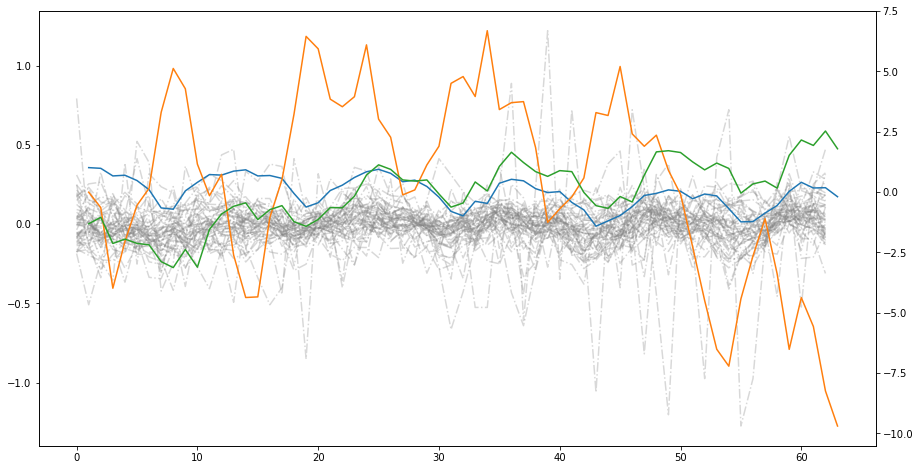

In [62]:
p = 3
seasons = 12
n = y.shape[1]
T = y.shape[0]
Sigma_u = np.eye(n)
sigma_xi = np.eye(p)
sigma_epsilon = np.eye(p)
sigma_eta = np.eye(p)
Sigma_v = block_diag(*[sigma_epsilon, sigma_eta, sigma_xi, np.zeros([(seasons-2)*p,(seasons-2)*p])])
C = block_diag(*[local_trend_component(p), seasonal_component(seasons, p)])
# Random guess for measurement matrix
L = np.random.normal(0,3, [n,p])
Astart = L
for m in [np.zeros([n,p]), L, np.zeros([n,(seasons-2)*p])]:
    Astart = np.concatenate([Astart, m], axis = 1)

model_brand = KF_DFM(y,None,None,Sigma_u,Sigma_v,Astart,None,C,None, p=p, n = 'default',sig0=5)
model_brand.EM(iters=20)
#         Zsmooth =pd.DataFrame([zs.reshape(len(zs))[:p] for zs in model_brand.zsmooth])[1:]
Zsmooth =pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:3*p] for zs in model_brand.zsmooth])[1:]
Zsmooth.columns = ['factor_'+str(c+1) for c in range(p)]
fig, ax1 = plt.subplots(figsize = (15,8))
colors = ['blue', 'orange', 'green']
# for i in range(p):
#     try:
#         y_ = np.mean(y[:, np.argmax(model_brand.L, axis = 1)==i], axis = 1)
#         y_n = np.mean(y[:, np.argmin(model_brand.L, axis = 1)==i], axis = 1)
#         ax1.plot(y_, alpha = .3,linestyle = '--', c = colors[i])
#         ax1.plot(y_n, alpha = .3,linestyle = '-.', c = colors[i])
#     except:
#         pass
ax1.plot(y,alpha = .3,linestyle = '-.', c = 'grey')
ax2 = plt.twinx(ax1)
ax2.plot(Zsmooth)

In [72]:
brandfactors = pd.DataFrame(model_brand.L, columns = ['factor_'+str(c) for c in range(p)])
brandfactors['brand'] = branddata.columns.values[1:]
brandfactors.sort_values(by = 'factor_1')

,factor_0,factor_1,factor_2,brand
4,-0.010403,-0.085007,0.000365,courtyard_by_marriott
12,-0.004034,-0.071821,-0.004046,hampton_inn
22,0.008988,-0.070090,0.004121,hyatt_place
21,0.012234,-0.060339,0.006540,hyatt_house
1,-0.004893,-0.056026,0.001615,best_western
7,-0.007568,-0.055636,-0.003311,doubletree
14,-0.002769,-0.054735,-0.002358,hilton_garden_inn
9,-0.024437,-0.050532,0.001749,embassy_suites
17,-0.004875,-0.048109,-0.002638,homewood_suites
42,-0.003423,-0.047619,0.002087,the_peninsula


In [85]:
for col in [c for c in df.columns.values if 'sub' in c]:
    try:
        branddata = df.groupby(['brand_filtered2','ym'])[col].mean().unstack('brand_filtered2').reset_index()
        branddata = branddata.loc[branddata.ym>datetime.date(2011, 12,31), :]
        branddata = branddata.interpolate(method='linear')
        drops = list()
        for c in branddata.columns.values:
            if list(branddata[c].isnull())[0]==True:
                drops.append(c)
        branddata.drop(drops, axis = 1, inplace = True)
        # y = np.array( branddata.groupby('ym').mean().apply(lambda x: zscore(x), axis =0))[:-2]
        from scipy.signal import detrend
        y = np.array( branddata.groupby('ym').mean().apply(lambda x: detrend(x, type = 'constant')))[:-2]

        p = 2
        seasons = 12
        n = y.shape[1]
        T = y.shape[0]
        Sigma_u = np.eye(n)
        sigma_xi = np.eye(p)
        sigma_epsilon = np.eye(p)
        sigma_eta = np.eye(p)
        Sigma_v = block_diag(*[sigma_epsilon, sigma_eta, sigma_xi, np.zeros([(seasons-2)*p,(seasons-2)*p])])
        C = block_diag(*[local_trend_component(p), seasonal_component(seasons, p)])
        # Random guess for measurement matrix
        L = np.random.normal(0,3, [n,p])
        Astart = L
        for m in [np.zeros([n,p]), L, np.zeros([n,(seasons-2)*p])]:
            Astart = np.concatenate([Astart, m], axis = 1)

        model_brand = KF_DFM(y,None,None,Sigma_u,Sigma_v,Astart,None,C,None, p=p, n = 'default',sig0=5)
        model_brand.EM(iters=20)
        #         Zsmooth =pd.DataFrame([zs.reshape(len(zs))[:p] for zs in model_brand.zsmooth])[1:]
        Zsmooth =pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:3*p] for zs in model_brand.zsmooth])[1:]
        Zsmooth.columns = ['factor_'+str(c+1) for c in range(p)]
        fig, ax1 = plt.subplots(figsize = (15,8))
        colors = ['blue', 'orange', 'green']
        # for i in range(p):
        #     try:
        #         y_ = np.mean(y[:, np.argmax(model_brand.L, axis = 1)==i], axis = 1)
        #         y_n = np.mean(y[:, np.argmin(model_brand.L, axis = 1)==i], axis = 1)
        #         ax1.plot(y_, alpha = .3,linestyle = '--', c = colors[i])
        #         ax1.plot(y_n, alpha = .3,linestyle = '-.', c = colors[i])
        #     except:
        #         pass
        ax1.plot(y,alpha = .3,linestyle = '-.', c = 'grey')
        ax2 = plt.twinx(ax1)
        ax2.plot(Zsmooth)
        plt.savefig('../../Figures/Exploratory/DFM/subrating_brand/'+str(col)+'_'+str(p)+'_factors.png')
        plt.close()
        brandfactors = pd.DataFrame(model_brand.L, columns = ['factor_'+str(c) for c in range(p)])
        brandfactors['brand'] = branddata.columns.values[1:]
        brandfactors.to_excel('../../Tables/Exploratory/DFM/subrating_brand/'+str(col)+'_'+str(p)+'_factors.xlsx')
        fig, ax = plt.subplots(figsize = (18,15))
        ax.scatter(brandfactors.factor_0, brandfactors.factor_1)
        for i,h in enumerate(branddata.columns.values[1:]):
            ax.annotate(h, (brandfactors.factor_0[i],brandfactors.factor_1[i]))
        plt.savefig('../../Figures/Exploratory/DFM/subrating_brand/'+str(col)+'_'+str(p)+'_factors_loading.png')
        plt.close()
    except:
        pass

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteratio

In [100]:
branddata = df.groupby(['brand_filtered2','ym'])[[c for c in df.columns.values if 'sub' in c]].mean().unstack('brand_filtered2').reset_index().swaplevel(i=0, j=1, axis=1)
branddata = branddata.loc[branddata.loc[:, ('', 'ym')]>datetime.date(2011, 12,31), :]
branddata = branddata.interpolate(method='linear')
drops = list()
for c in branddata.columns.values:
    if list(branddata[c].isnull())[0]==True:
        drops.append(c)
branddata.drop(drops, axis = 1, inplace = True)

In [112]:
for b in df.brand_filtered2.unique():
    try:
        y = np.array(branddata[b].apply(lambda x: detrend(x, type = 'constant')))[:-2]
        p = 2
        seasons = 12
        n = y.shape[1]
        T = y.shape[0]
        Sigma_u = np.eye(n)
        sigma_xi = np.eye(p)
        sigma_epsilon = np.eye(p)
        sigma_eta = np.eye(p)
        Sigma_v = block_diag(*[sigma_epsilon, sigma_eta, sigma_xi, np.zeros([(seasons-2)*p,(seasons-2)*p])])
        C = block_diag(*[local_trend_component(p), seasonal_component(seasons, p)])
        # Random guess for measurement matrix
        L = np.random.normal(0,3, [n,p])
        Astart = L
        for m in [np.zeros([n,p]), L, np.zeros([n,(seasons-2)*p])]:
            Astart = np.concatenate([Astart, m], axis = 1)
        model_brand = KF_DFM(y,None,None,Sigma_u,Sigma_v,Astart,None,C,None, p=p, n = 'default',sig0=5)
        model_brand.EM(iters=20)
        #         Zsmooth =pd.DataFrame([zs.reshape(len(zs))[:p] for zs in model_brand.zsmooth])[1:]
        Zsmooth =pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:3*p] for zs in model_brand.zsmooth])[1:]
        Zsmooth.columns = ['factor_'+str(c+1) for c in range(p)]

        brandfactors = pd.DataFrame(model_brand.L, columns = ['factor_'+str(c) for c in range(p)])
        brandfactors['subratings'] = branddata[b].columns.values
        brandfactors.to_excel('../../Tables/Exploratory/DFM/subrating_brand/'+str(b)+'_'+str(p)+'_factors.xlsx')
        fig, ax = plt.subplots(figsize = (7,7))
        ax.scatter(brandfactors.factor_0, brandfactors.factor_1)
        for i,h in enumerate(branddata[b].columns.values):
            ax.annotate(h, (brandfactors.factor_0[i],brandfactors.factor_1[i]))
        plt.savefig('../../Figures/Exploratory/DFM/subrating_by_brand/'+str(b)+'_'+str(p)+'_factors_loading.png')
        plt.close()
    except:
        pass

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iter

Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 0
Iteration: 

In [114]:
os.listdir('../../Data/')

['BrandIndex Version 6.0 Questions (English).pdf',
 'branded_url.txt',
 'checklist.xlsx',
 '2017 03 10 BrandIndex Global Active Brands List.xlsx',
 'brand2token copy.csv',
 'Brand_Data_Full',
 'brandgd.txt',
 'reputationscore.xlsx',
 'brand_data_combined.txt',
 'Misc',
 'yougov_restaurant_hotels.xlsx',
 'brandgd_missing_2.txt',
 'gdlist.txt',
 'brandgd_missing.txt',
 'gd_brand_url.txt',
 'working_data',
 'brand2token.csv']

In [177]:
yg = pd.read_csv('../../Data/brand_data_combined.txt', sep = '|', header = [0,1,2], index_col = 0)
cols = [c[1:] for c in yg.columns.values if ('Hotel' in c[0])&('Score' in c[2])]
cols2 =[c for c in yg.columns.values if ('Hotel' in c[0])&('Score' in c[2])]
yg = yg[cols2]
index = pd.MultiIndex.from_tuples(cols)
yg.columns = index

In [ ]:
for b in set([c[0] for c in cols]):
    try:
        y = np.array(yg[b].apply(lambda x: detrend(x, type = 'constant')))[:-2]
        p = 2
        seasons = 365
        n = y.shape[1]
        T = y.shape[0]
        Sigma_u = np.eye(n)
        sigma_xi = np.eye(p)
        sigma_epsilon = np.eye(p)
        sigma_eta = np.eye(p)
        Sigma_v = block_diag(*[sigma_epsilon, sigma_eta, sigma_xi, np.zeros([(seasons-2)*p,(seasons-2)*p])])
        C = block_diag(*[local_trend_component(p), seasonal_component(seasons, p)])
        # Random guess for measurement matrix
        L = np.random.normal(0,3, [n,p])
        Astart = L
        for m in [np.zeros([n,p]), L, np.zeros([n,(seasons-2)*p])]:
            Astart = np.concatenate([Astart, m], axis = 1)
        model_yg = KF_DFM(y,None,None,Sigma_u,Sigma_v,Astart,None,C,None, p=p, n = 'default',sig0=5)
        model_yg.EM(iters=20)
        ygfactors = pd.DataFrame(model_yg.L, columns = ['factor_'+str(c) for c in range(p)])
        ygfactors['subratings'] = yg[b].columns.values
        fig, ax = plt.subplots(figsize = (7,7))
        ax.scatter(ygfactors.factor_0, ygfactors.factor_1)
        for i,h in enumerate(yg[b].columns.values):
            ax.annotate(h.replace('_Score', ''), (ygfactors.factor_0[i],ygfactors.factor_1[i]))
        plt.savefig('../../Figures/Exploratory/DFM/yougov/2_factor/loadings/'+str(b)+'_'+str(p)+'_factors_loading.png')
        plt.close()
        # State space graphs
        Zsmooth =pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:3*p] for zs in model_yg.zsmooth])[1:]
        Zsmooth.columns = ['factor_'+str(c+1) for c in range(p)]
        fig, ax1 = plt.subplots(figsize = (15,8))
        colors = ['blue', 'orange', 'green']
        for i in range(p):
            try:
                y_ = np.mean(y[:, np.argmax(model.L, axis = 1)==i], axis = 1)
                y_n = np.mean(y[:, np.argmin(model.L, axis = 1)==i], axis = 1)
                ax1.plot(y_, alpha = .01,linestyle = '--', c = colors[i])
                ax1.plot(y_n, alpha = .01,linestyle = '-.', c = colors[i])
            except:
                pass
        ax2 = plt.twinx(ax1)
        ax2.plot(Zsmooth)
        plt.savefig('../../Figures/Exploratory/DFM/yougov/2_factor/states/'+str(b)+'_'+str(p)+'_factors_state.png')
        plt.close()
        
    except:
        pass

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 15 but corresponding boolean dimension is 3
  import sys
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 15 but corresponding boolean dimension is 3
  


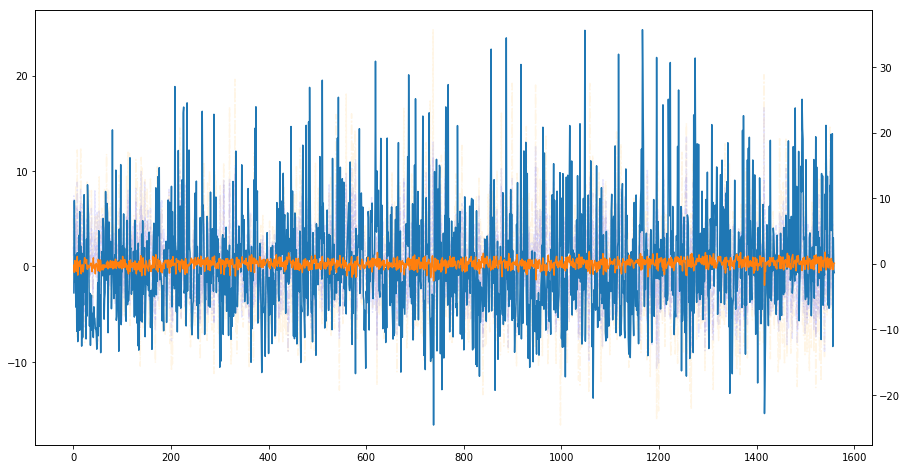

In [217]:
Zsmooth =pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:3*p] for zs in model_yg.zsmooth])[1:]
Zsmooth.columns = ['factor_'+str(c+1) for c in range(p)]
fig, ax1 = plt.subplots(figsize = (15,8))
colors = ['blue', 'orange', 'green']
for i in range(p):
    try:
        y_ = np.mean(y[:, np.argmax(model.L, axis = 1)==i], axis = 1)
        y_n = np.mean(y[:, np.argmin(model.L, axis = 1)==i], axis = 1)
        ax1.plot(y_, alpha = .1,linestyle = '--', c = colors[i])
        ax1.plot(y_n, alpha = .1,linestyle = '-.', c = colors[i])
    except:
        pass
ax2 = plt.twinx(ax1)
ax2.plot(Zsmooth)

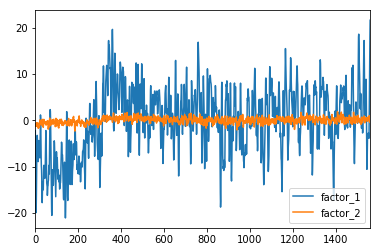

In [207]:
Zsmooth =pd.DataFrame([zs.reshape(len(zs))[:p] for zs in model_yg.zsmooth])[1:]
Zsmooth.columns = ['factor_'+str(c+1) for c in range(p)]
Zsmooth.plot()

## Imputation code